<a href="https://colab.research.google.com/github/JCaballerot/Recommender_Systems/blob/main/Hybrid_Recommender/Book_Crossing_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


<h1 align=center><font size = 5> Hybrid
 Recommender</font></h1>

---

<center>
  <img src="https://storage.googleapis.com/kaggle-datasets-images/1661575/2726067/684ac0c4c14cb46d1047ccb620b45cac/dataset-cover.jpg?t=2021-10-21-03-18-09" width="800" height="300">
</center>


## Objetivo de este Notebook

1. Cargar y preprocesar un Dataset.
2. Realizar un sistema de recomendación basado en hybrid methods.
3. Comprobar el performance del sistema.

## Tabla de Contenidos

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>
    
1. <a href="#item31">Contexto</a>  
2. <a href="#item32">Descargar y preparar el Dataset</a>  
6. <a href="#item34">Entrenamiento del modelo</a>  
6. <a href="#item34">Validación del modelo</a>  

</font>
</div>

### 1. Contexto


El conjunto de datos "Book-Crossing" (también conocido como BX) es una colección de datos relacionados con libros y reseñas de libros. Este conjunto de datos se centra en la interacción de los usuarios con libros y sus calificaciones, y es ampliamente utilizado en aplicaciones de sistemas de recomendación.


<b>Descripción de datos</b>


El conjunto de datos Book-Crossing contiene información sobre:

---


<b>Usuarios (BX-Users):</b>

Contiene la información del usuario. Los campos incluyen:

* User-ID: Un identificador único para cada usuario.
* Location: La ubicación del usuario.
* Age: La edad del usuario.




<b>Libros (BX-Books):</b>

Contiene la información de los libros. Los campos incluyen:

* ISBN: Número de ISBN del libro, que es un identificador único.
* Book-Title: El título del libro.
* Book-Author: El autor del libro.
* Year-Of-Publication: El año de publicación del libro.
* Publisher: El editor del libro.
* Otras informaciones adicionales sobre los libros.




<b>Evaluaciones (BX-Book-Ratings):</b>

Contiene las evaluaciones de los libros. Los campos incluyen:

* User-ID: El identificador del usuario que dio la evaluación.
* ISBN: El ISBN del libro evaluado.
* Book-Rating: La calificación del libro en una escala (por lo general, de 1 a 10).




---



<strong>Puede consultar este [link](https://www.kaggle.com/datasets/syedjaferk/book-crossing-dataset) para leer más sobre la fuente de datos Book Crossing.</strong>

### 2. Descargar y preparar Dataset

In [9]:
# Download Book-Crossing Dataset
!curl -o dataset.zip "http://www2.informatik.uni-freiburg.de/~cziegler/BX/BX-CSV-Dump.zip"
!unzip dataset.zip
!ls -la

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   196  100   196    0     0    409      0 --:--:-- --:--:-- --:--:--   410
Archive:  dataset.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of dataset.zip or
        dataset.zip.zip, and cannot find dataset.zip.ZIP, period.
total 117956
drwxr-xr-x 1 root root     4096 Nov 18 15:34 .
drwxr-xr-x 1 root root     4096 Nov 18 15:04 ..
-rw-r--r-- 1 root root 30682276 Oct 14 14:59 BX-Book-Ratings.csv
-rw-r--r-- 1 root root 77787439 Oct 14 15:00 BX-Books.csv
-rw-r--r-- 1 root root 12284157 Oct 14 15:00 BX-Users.csv
drwxr-xr-x 4 root root     4096 Nov 16 14:23 .config
-rw-r--r-- 1 ro

In [10]:
!curl -L -o dataset.zip "https://drive.google.com/uc?id=1P7_nW6mZAVgf7sDqdm3SaR9_ZaCOeyjI&export=download&authuser=0"
!unzip dataset.zip
!ls -la

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:--  0:00:02 --:--:--     0
100 24.6M  100 24.6M    0     0  7709k      0  0:00:03  0:00:03 --:--:--  121M
Archive:  dataset.zip
replace BX-Users.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N
total 143168
drwxr-xr-x 1 root root     4096 Nov 18 15:34 .
drwxr-xr-x 1 root root     4096 Nov 18 15:04 ..
-rw-r--r-- 1 root root 30682276 Oct 14 14:59 BX-Book-Ratings.csv
-rw-r--r-- 1 root root 77787439 Oct 14 15:00 BX-Books.csv
-rw-r--r-- 1 root root 12284157 Oct 14 15:00 BX-Users.csv
drwxr-xr-x 4 root root     4096 Nov 16 14:23 .config
-rw-r--r-- 1 root root 25820794 Nov 18 15:35 dataset.zip
drwxr-xr-x 2 root root     4096 Nov 18 15:34 __MACOSX
drwxr-xr-x 1 root root     4096 Nov 16 14:27 sample_data


In [11]:
# Principales librerías
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore") # Turn off warnings


In [12]:
ratings = pd.read_csv("BX-Book-Ratings.csv", sep=";", encoding="ISO-8859-1")
books   = pd.read_csv("BX-Books.csv",        sep=";", encoding="ISO-8859-1", error_bad_lines=False)
users   = pd.read_csv("BX-Users.csv",        sep=";", encoding="ISO-8859-1")

Skipping line 6452: expected 8 fields, saw 9
Skipping line 43667: expected 8 fields, saw 10
Skipping line 51751: expected 8 fields, saw 9

Skipping line 92038: expected 8 fields, saw 9
Skipping line 104319: expected 8 fields, saw 9
Skipping line 121768: expected 8 fields, saw 9

Skipping line 144058: expected 8 fields, saw 9
Skipping line 150789: expected 8 fields, saw 9
Skipping line 157128: expected 8 fields, saw 9
Skipping line 180189: expected 8 fields, saw 9
Skipping line 185738: expected 8 fields, saw 9

Skipping line 209388: expected 8 fields, saw 9
Skipping line 220626: expected 8 fields, saw 9
Skipping line 227933: expected 8 fields, saw 11
Skipping line 228957: expected 8 fields, saw 10
Skipping line 245933: expected 8 fields, saw 9
Skipping line 251296: expected 8 fields, saw 9
Skipping line 259941: expected 8 fields, saw 9
Skipping line 261529: expected 8 fields, saw 9



In [13]:
users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [14]:
books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


<b>Calificaciones explícitas</b>: Están expresadas en una escala del 1-10 (más alta) y representan una calificación explícita por parte del usuario.

<b>Calificaciones implícitas</b>: Son expresadas por un 0, indicando que no hay una calificación explícita. En el contexto de este dataset, una calificación de 0 indica una interacción implícita con el libro (por ejemplo, el usuario lo compró o leyó), pero no proporciona una calificación explícita del contenido.

In [15]:
ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [16]:
print("  Users: {} \n  Books: {}\n  Ratings: {}".format(len(users), len(books), len(ratings)))


  Users: 278858 
  Books: 271360
  Ratings: 1149780


In [17]:
users.columns = users.columns.str.lower().str.replace('-', '_')
books.columns = books.columns.str.lower().str.replace('-', '_')
ratings.columns = ratings.columns.str.lower().str.replace('-', '_')

### 3. Uniendo data

In [18]:
# Analizaremos únicamente los datos explicitos del usuario-item
ratings = ratings[ratings.book_rating > 0]

In [19]:
ratings.head()

,user_id,isbn,book_rating
1,276726,0155061224,5
3,276729,052165615X,3
4,276729,0521795028,6
6,276736,3257224281,8
7,276737,0600570967,6


In [20]:
# Cruzamos las bases de datos para  obtener una tabla única

data = pd.merge(ratings, users, on = 'user_id', how = 'left')
data = pd.merge(data,    books, on = 'isbn', how = 'left')
data.drop(columns = ['image_url_s', 'image_url_m', 'image_url_l'], inplace = True)

data.head()

,user_id,isbn,book_rating,location,age,book_title,book_author,year_of_publication,publisher
0,276726,0155061224,5,"seattle, washington, usa",NaN,Rites of Passage,Judith Rae,2001,Heinle
1,276729,052165615X,3,"rijeka, n/a, croatia",16.0,Help!: Level 1,Philip Prowse,1999,Cambridge University Press
2,276729,0521795028,6,"rijeka, n/a, croatia",16.0,The Amsterdam Connection : Level 4 (Cambridge ...,Sue Leather,2001,Cambridge University Press
3,276736,3257224281,8,"salzburg, salzburg, austria",NaN,NaN,NaN,NaN,NaN
4,276737,0600570967,6,"sydney, new south wales, australia",14.0,NaN,NaN,NaN,NaN


<Axes: xlabel='book_rating', ylabel='Count'>

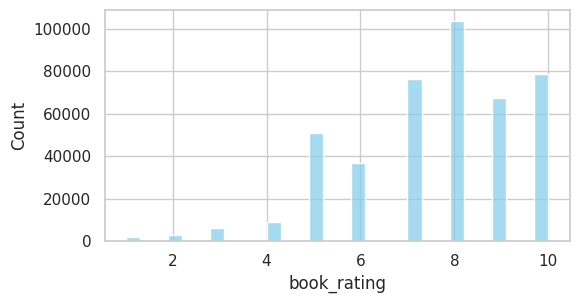

In [21]:
# Estilo de Seaborn
sns.set(style="whitegrid")
# figura y eje
plt.figure(figsize=(6, 3))
sns.histplot(data.book_rating, bins=30, kde=False, color="skyblue")

In [22]:
#tratando información del año de publicación
data.year_of_publication = pd.to_numeric(data.year_of_publication, errors='coerce')


In [23]:
# Ejemplo de remoción de outliers
lower_threshold = 1964
upper_threshold = 2004

data = data[(data['year_of_publication'] >= lower_threshold) & (data['year_of_publication'] <= upper_threshold)]
data.year_of_publication = data.year_of_publication.astype(int)

In [24]:
#Creando antiguedad del libro
data['antiguedad'] = 2008 - data.year_of_publication

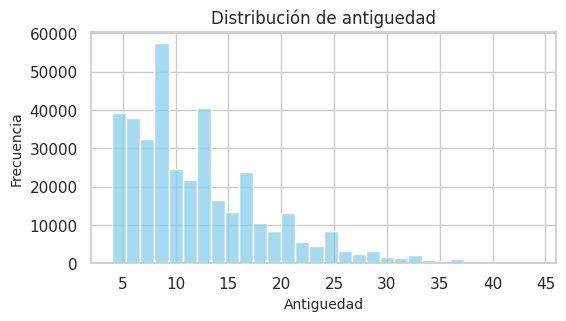

In [25]:
# Estilo de Seaborn
sns.set(style="whitegrid")

# figura y eje
plt.figure(figsize=(6, 3))

# histograma
sns.histplot(data.antiguedad, bins=30, kde=False, color="skyblue")

# título y etiquetas a los ejes
plt.title('Distribución de antiguedad', fontsize=12)
plt.xlabel('Antiguedad', fontsize=10)
plt.ylabel('Frecuencia', fontsize=10)

# Muestra el histograma
plt.show()

In [26]:
books_list = data.groupby('book_title')['user_id'].count().reset_index()
books_list.sort_values(by = 'user_id', ascending = False, inplace = True)

print(f"{len(books_list)} libros diferentes, nos quedaremos con los más populares para no saturar nuestro Recsys")

132690 libros diferentes, nos quedaremos con los más populares para no saturar nuestro Recsys


In [27]:
books_list

,book_title,user_id
107718,The Lovely Bones: A Novel,707
129426,Wild Animus,581
100247,The Da Vinci Code,494
113652,The Secret Life of Bees,406
109430,The Nanny Diaries: A Novel,393
...,...,...
53436,Julius Caesar: No Fear (No Fear Shakespeare),1
53433,Julius Caesar (Nouveau Siecle),1
53431,Julius Caesar (Folger Shakespeare Library),1
53429,Julius Caesar (Classics Illustrated),1


In [28]:
books_list[:500]

,book_title,user_id
107718,The Lovely Bones: A Novel,707
129426,Wild Animus,581
100247,The Da Vinci Code,494
113652,The Secret Life of Bees,406
109430,The Nanny Diaries: A Novel,393
...,...,...
70877,Night Sins,59
111062,The Phantom Tollbooth,59
77142,Plum Island,59
51865,It Was on Fire When I Lay Down on It,59


In [29]:
# Calculamos los libros más populares
pop_books = books_list[:500].book_title.tolist()

In [30]:
data_v2 = data[data.book_title.isin(pop_books)]

In [31]:
data_v2.head()

,user_id,isbn,book_rating,location,age,book_title,book_author,year_of_publication,publisher,antiguedad
5,276744,038550120X,7,"torrance, california, usa",NaN,A Painted House,JOHN GRISHAM,2001,Doubleday,7
14,276754,0684867621,8,"alberta beach, alberta, canada",19.0,The Girl Who Loved Tom Gordon : A Novel,Stephen King,1999,Scribner,9
15,276755,0451166892,5,"frankfurt am main, hessen, germany",32.0,The Pillars of the Earth,Ken Follett,1996,Signet Book,12
33,276788,043935806X,7,"mentone, california, usa",NaN,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,5
34,276788,055310666X,10,"mentone, california, usa",NaN,False Memory,Dean R. Koontz,1999,Bantam Books,9


Dicotomizaremos la variable objetivo para que el modelo aprenda la probabilidad de que el cliente tenga afinidad con el libro. Esta estrategia es bastante utilizada en las aplicaciones de Recsys pero no olvidemos que también se puede apuntar a predecir directamente el rating del cliente.

In [32]:
data_v2['target'] = data_v2.book_rating.apply(lambda x: 1 if x > 7 else 0)

In [33]:
data_v2.head()

,user_id,isbn,book_rating,location,age,book_title,book_author,year_of_publication,publisher,antiguedad,target
5,276744,038550120X,7,"torrance, california, usa",NaN,A Painted House,JOHN GRISHAM,2001,Doubleday,7,0
14,276754,0684867621,8,"alberta beach, alberta, canada",19.0,The Girl Who Loved Tom Gordon : A Novel,Stephen King,1999,Scribner,9,1
15,276755,0451166892,5,"frankfurt am main, hessen, germany",32.0,The Pillars of the Earth,Ken Follett,1996,Signet Book,12,0
33,276788,043935806X,7,"mentone, california, usa",NaN,Harry Potter and the Order of the Phoenix (Boo...,J. K. Rowling,2003,Scholastic,5,0
34,276788,055310666X,10,"mentone, california, usa",NaN,False Memory,Dean R. Koontz,1999,Bantam Books,9,1


Text(0.5, 1.0, '¿La data presenta desbalance?')

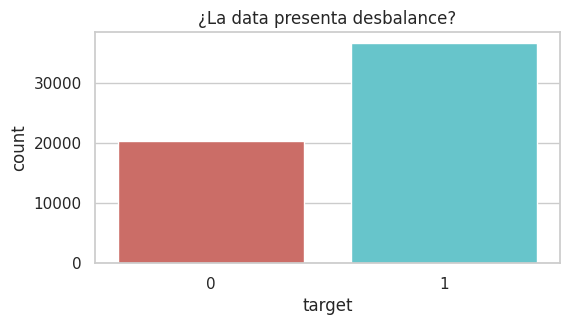

In [34]:
# figura y eje
plt.figure(figsize=(6, 3))
# Analizando el target
sns.countplot(x='target', data = data_v2, palette = 'hls')
plt.title('¿La data presenta desbalance?', fontsize=12)


### 4. Muestreo de datos

In [35]:
# Muestreo de data
from sklearn.model_selection import train_test_split

train, test = train_test_split(data_v2,
                               stratify = data_v2.target, # Recuerda estratificar para evitar sesgos durante el muestreo
                               train_size = 0.6,
                               random_state = 123)

watch, test = train_test_split(test,
                               stratify = test.target, # Recuerda estratificar para evitar sesgos durante el muestreo
                               train_size = 0.5,
                               random_state = 123)

# El muestreo puede hacerse por cliente o por enmascaramiento como en anteriores ejercicios.

### 5. Tratamiento de variables

Variable de locacion

In [36]:
train.head()

,user_id,isbn,book_rating,location,age,book_title,book_author,year_of_publication,publisher,antiguedad,target
111281,66942,0804114986,2,"kuching, sarawak, malaysia",31.0,The Bonesetter's Daughter,Amy Tan,2002,Ballantine Books,6,0
396183,250184,0061009059,8,"renton, washington, usa",NaN,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch,13,1
239775,146745,0446670251,8,"dunedin, otago, new zealand",33.0,The Virgin Suicides,Jeffrey Eugenides,1994,Warner Books,14,1
233689,142357,0316284955,7,"evergreen, colorado, usa",NaN,White Oleander : A Novel (Oprah's Book Club),Janet Fitch,2000,Back Bay Books,8,0
92630,54704,0451184963,3,"london, ontario, canada",NaN,Insomnia,Stephen King,1995,Signet Book,13,0


In [37]:
temp = train.groupby('location')['user_id'].count().reset_index()
temp.sort_values(by = 'user_id', ascending = False)

,location,user_id
5750,"toronto, ontario, canada",394
1032,"chicago, illinois, usa",349
3836,"n/a, n/a, n/a",304
4559,"portland, oregon, usa",300
5002,"san diego, california, usa",267
...,...,...
3666,"molalla, ,",1
3669,"monee, illinois, usa",1
1077,"clarksville, maryland, usa",1
3673,"monona, ,",1


In [38]:
# Función para extraer los n últimos elementos y unirlos con ','
def extract_last_n(location, n):
    parts = location.split(', ')
    return ', '.join(parts[-n:])

# Generar agregaciones
train['location_level2'] = train['location'].apply(lambda x: extract_last_n(x, 2))
train['location_level3'] = train['location'].apply(lambda x: extract_last_n(x, 1))

test['location_level2'] = test['location'].apply(lambda x: extract_last_n(x, 2))
test['location_level3'] = test['location'].apply(lambda x: extract_last_n(x, 1))

watch['location_level2'] = watch['location'].apply(lambda x: extract_last_n(x, 2))
watch['location_level3'] = watch['location'].apply(lambda x: extract_last_n(x, 1))

In [39]:
train.head()

,user_id,isbn,book_rating,location,age,book_title,book_author,year_of_publication,publisher,antiguedad,target,location_level2,location_level3
111281,66942,0804114986,2,"kuching, sarawak, malaysia",31.0,The Bonesetter's Daughter,Amy Tan,2002,Ballantine Books,6,0,"sarawak, malaysia",malaysia
396183,250184,0061009059,8,"renton, washington, usa",NaN,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch,13,1,"washington, usa",usa
239775,146745,0446670251,8,"dunedin, otago, new zealand",33.0,The Virgin Suicides,Jeffrey Eugenides,1994,Warner Books,14,1,"otago, new zealand",new zealand
233689,142357,0316284955,7,"evergreen, colorado, usa",NaN,White Oleander : A Novel (Oprah's Book Club),Janet Fitch,2000,Back Bay Books,8,0,"colorado, usa",usa
92630,54704,0451184963,3,"london, ontario, canada",NaN,Insomnia,Stephen King,1995,Signet Book,13,0,"ontario, canada",canada


In [40]:
temp = train.groupby('location_level2')['user_id'].count().reset_index()
temp = temp[temp.user_id > 30]
temp.sort_values(by = 'user_id', ascending = False)

,location_level2,user_id
182,"california, usa",4025
973,"texas, usa",1703
761,"ontario, canada",1298
325,"florida, usa",1239
417,"illinois, usa",1199
...,...,...
902,"scotland, united kingdom",42
199,"catalunya, spain",40
91,"baden-wuerttemberg, germany",36
721,"north dakota, usa",34


In [41]:
temp = train.groupby('location_level3')['user_id'].count().reset_index()
temp = temp[temp.user_id > 30]
temp.sort_values(by = 'user_id', ascending = False)

,location_level3,user_id
152,usa,26478
22,canada,3156
0,",",783
144,united kingdom,687
9,australia,452
84,n/a,304
46,germany,289
111,portugal,252
74,malaysia,229
128,spain,172


In [42]:
# Creando variable mixta de locacion
train['location_f'] = train.apply(lambda row: row['location_level2'] if row['location_level3'] == 'usa' else row['location_level3'], axis=1)
test['location_f']  = test.apply(lambda row: row['location_level2'] if row['location_level3'] == 'usa' else row['location_level3'], axis=1)
watch['location_f'] = watch.apply(lambda row: row['location_level2'] if row['location_level3'] == 'usa' else row['location_level3'], axis=1)


In [43]:
train.head()

,user_id,isbn,book_rating,location,age,book_title,book_author,year_of_publication,publisher,antiguedad,target,location_level2,location_level3,location_f
111281,66942,0804114986,2,"kuching, sarawak, malaysia",31.0,The Bonesetter's Daughter,Amy Tan,2002,Ballantine Books,6,0,"sarawak, malaysia",malaysia,malaysia
396183,250184,0061009059,8,"renton, washington, usa",NaN,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch,13,1,"washington, usa",usa,"washington, usa"
239775,146745,0446670251,8,"dunedin, otago, new zealand",33.0,The Virgin Suicides,Jeffrey Eugenides,1994,Warner Books,14,1,"otago, new zealand",new zealand,new zealand
233689,142357,0316284955,7,"evergreen, colorado, usa",NaN,White Oleander : A Novel (Oprah's Book Club),Janet Fitch,2000,Back Bay Books,8,0,"colorado, usa",usa,"colorado, usa"
92630,54704,0451184963,3,"london, ontario, canada",NaN,Insomnia,Stephen King,1995,Signet Book,13,0,"ontario, canada",canada,canada


**Encoding**

El encoding de variables categóricas convierte las categorías de texto en números de una manera que puede ser utilizada de manera eficiente por los algoritmos de machine learning.


In [44]:
train.head()

,user_id,isbn,book_rating,location,age,book_title,book_author,year_of_publication,publisher,antiguedad,target,location_level2,location_level3,location_f
111281,66942,0804114986,2,"kuching, sarawak, malaysia",31.0,The Bonesetter's Daughter,Amy Tan,2002,Ballantine Books,6,0,"sarawak, malaysia",malaysia,malaysia
396183,250184,0061009059,8,"renton, washington, usa",NaN,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch,13,1,"washington, usa",usa,"washington, usa"
239775,146745,0446670251,8,"dunedin, otago, new zealand",33.0,The Virgin Suicides,Jeffrey Eugenides,1994,Warner Books,14,1,"otago, new zealand",new zealand,new zealand
233689,142357,0316284955,7,"evergreen, colorado, usa",NaN,White Oleander : A Novel (Oprah's Book Club),Janet Fitch,2000,Back Bay Books,8,0,"colorado, usa",usa,"colorado, usa"
92630,54704,0451184963,3,"london, ontario, canada",NaN,Insomnia,Stephen King,1995,Signet Book,13,0,"ontario, canada",canada,canada


In [45]:
catergory_features = ['book_title', 'book_author', 'publisher', 'location_f']

In [46]:
%%capture
!pip3 install category_encoders

In [47]:
# Aplicando category encoders
from category_encoders import TargetEncoder

encoder = TargetEncoder(handle_unknown = 'infrequent_if_exist',
                        handle_missing = 'value',
                        min_samples_leaf = 30)

encoder.fit(train[catergory_features].astype('category'), train['target'])


TargetEncoder(cols=['book_title', 'book_author', 'publisher', 'location_f'],
              handle_unknown='infrequent_if_exist', min_samples_leaf=30)

In [48]:
# Aplicando transformaciones sobre  variables

train[[x + '_coded' for x in catergory_features]] = encoder.transform(train[catergory_features].astype('category'))
test[[x + '_coded' for x in catergory_features]]  = encoder.transform(test[catergory_features].astype('category'))
watch[[x + '_coded' for x in catergory_features]] = encoder.transform(watch[catergory_features].astype('category'))


In [49]:
train.head()

,user_id,isbn,book_rating,location,age,book_title,book_author,year_of_publication,publisher,antiguedad,target,location_level2,location_level3,location_f,book_title_coded,book_author_coded,publisher_coded,location_f_coded
111281,66942,0804114986,2,"kuching, sarawak, malaysia",31.0,The Bonesetter's Daughter,Amy Tan,2002,Ballantine Books,6,0,"sarawak, malaysia",malaysia,malaysia,0.724398,0.722955,0.595964,0.567686
396183,250184,0061009059,8,"renton, washington, usa",NaN,One for the Money (Stephanie Plum Novels (Pape...,Janet Evanovich,1995,HarperTorch,13,1,"washington, usa",usa,"washington, usa",0.641975,0.687500,0.626186,0.620829
239775,146745,0446670251,8,"dunedin, otago, new zealand",33.0,The Virgin Suicides,Jeffrey Eugenides,1994,Warner Books,14,1,"otago, new zealand",new zealand,new zealand,0.687196,0.736821,0.646703,0.617063
233689,142357,0316284955,7,"evergreen, colorado, usa",NaN,White Oleander : A Novel (Oprah's Book Club),Janet Fitch,2000,Back Bay Books,8,0,"colorado, usa",usa,"colorado, usa",0.660544,0.634259,0.632873,0.644898
92630,54704,0451184963,3,"london, ontario, canada",NaN,Insomnia,Stephen King,1995,Signet Book,13,0,"ontario, canada",canada,canada,0.650480,0.609756,0.607493,0.610900


### 6. XGBoost




In [50]:
import xgboost as xgb
from sklearn.metrics import *

In [51]:
features = ['age', 'antiguedad', 'book_title_coded', 'book_author_coded', 'publisher_coded', 'location_f_coded']

In [52]:
# Definimos los parámetros para el Grid Search

param_grid = {'objective': ['binary:logistic'],
              'booster' : ['gbtree'],
              'learning_rate': [0.01, 0.05, 0.1],
              'max_depth': [3, 5, 7],
              'colsample_bytree': [0.7, 1],
              'subsample': [0.7, 1]}


In [53]:
%%time
from sklearn.model_selection import GridSearchCV

# Crear clasificador
xgBoost = xgb.XGBClassifier(use_label_encoder=False, n_estimators = 500)


# Crear objeto GridSearchCV
grid_search = GridSearchCV(xgBoost,
                           param_grid,
                           scoring = make_scorer(auc),
                           cv = 3,  # Número de folds en la validación cruzada
                           verbose = 2,  # Verbosidad del output
                           n_jobs = -1  # Uso de todos los núcleos disponibles
                          )

# Realizar búsqueda de parámetros
grid_search.fit(train[features],
                train.target,
                early_stopping_rounds = 10,
                eval_metric = "auc",
                eval_set=[(watch[features], watch.target)],
                verbose = True)



Fitting 3 folds for each of 36 candidates, totalling 108 fits
[0]	validation_0-auc:0.61707
[1]	validation_0-auc:0.61923
[2]	validation_0-auc:0.62963
[3]	validation_0-auc:0.62668
[4]	validation_0-auc:0.63052
[5]	validation_0-auc:0.63158
[6]	validation_0-auc:0.63142
[7]	validation_0-auc:0.63205
[8]	validation_0-auc:0.63184
[9]	validation_0-auc:0.63278
[10]	validation_0-auc:0.63280
[11]	validation_0-auc:0.63215
[12]	validation_0-auc:0.63276
[13]	validation_0-auc:0.63277
[14]	validation_0-auc:0.63272
[15]	validation_0-auc:0.63279
[16]	validation_0-auc:0.63279
[17]	validation_0-auc:0.63269
[18]	validation_0-auc:0.63322
[19]	validation_0-auc:0.63358
[20]	validation_0-auc:0.63381
[21]	validation_0-auc:0.63370
[22]	validation_0-auc:0.63383
[23]	validation_0-auc:0.63369
[24]	validation_0-auc:0.63405
[25]	validation_0-auc:0.63439
[26]	validation_0-auc:0.63441
[27]	validation_0-auc:0.63437
[28]	validation_0-auc:0.63419
[29]	validation_0-auc:0.63432
[30]	validation_0-auc:0.63413
[31]	validation_0-

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None,...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=500,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'booster': ['gbtree'], 'colsample_bytree': [0.7, 1],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 5, 7],
                         'objective': ['binary:logistic'],
                         'subsample': [0.7, 1]},
             scoring=make_scorer(auc), verbose=2)

In [54]:
# Obtener el mejor modelo
best_model = grid_search.best_estimator_

# Si deseas, también puedes extraer y visualizar los mejores parámetros encontrados
best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")


Best parameters found: {'booster': 'gbtree', 'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'objective': 'binary:logistic', 'subsample': 0.7}


In [55]:
%%capture
!pip install --upgrade xgboost

In [56]:
# Entrenando el modelo final

xgBoost = xgb.XGBClassifier(use_label_encoder=False,
                            n_estimators = 500, **best_params)

xgBoost.fit(train[features],
            train.target,
            early_stopping_rounds=10,
            eval_metric="auc",
            eval_set=[(train[features], train.target), (watch[features], watch.target)],
            verbose=True)


# Extraer los resultados de evaluación
results = xgBoost.evals_result()


[0]	validation_0-auc:0.62963	validation_1-auc:0.61707
[1]	validation_0-auc:0.63255	validation_1-auc:0.61923
[2]	validation_0-auc:0.65525	validation_1-auc:0.62963
[3]	validation_0-auc:0.65134	validation_1-auc:0.62668
[4]	validation_0-auc:0.65631	validation_1-auc:0.63052
[5]	validation_0-auc:0.65782	validation_1-auc:0.63158
[6]	validation_0-auc:0.65861	validation_1-auc:0.63142
[7]	validation_0-auc:0.65947	validation_1-auc:0.63205
[8]	validation_0-auc:0.65965	validation_1-auc:0.63184
[9]	validation_0-auc:0.66046	validation_1-auc:0.63278
[10]	validation_0-auc:0.66071	validation_1-auc:0.63280
[11]	validation_0-auc:0.66026	validation_1-auc:0.63215
[12]	validation_0-auc:0.66071	validation_1-auc:0.63276
[13]	validation_0-auc:0.66075	validation_1-auc:0.63277
[14]	validation_0-auc:0.66050	validation_1-auc:0.63272
[15]	validation_0-auc:0.66039	validation_1-auc:0.63279
[16]	validation_0-auc:0.66055	validation_1-auc:0.63279
[17]	validation_0-auc:0.66066	validation_1-auc:0.63269
[18]	validation_0-au

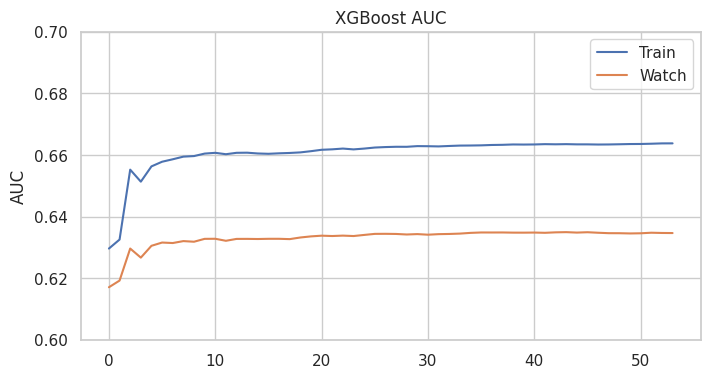

In [57]:
epochs = len(results['validation_0']['auc'])
x_axis = range(0, epochs)

# Ajusta el tamaño
fig, ax = plt.subplots(figsize=(8, 4))

ax.plot(x_axis, results['validation_0']['auc'], label='Train')
ax.plot(x_axis, results['validation_1']['auc'], label='Watch')

ax.set_ylim([0.6, 0.7])  # Para limitar la cantidad de epochs

ax.legend()
plt.ylabel('AUC')
plt.title('XGBoost AUC')
plt.show()

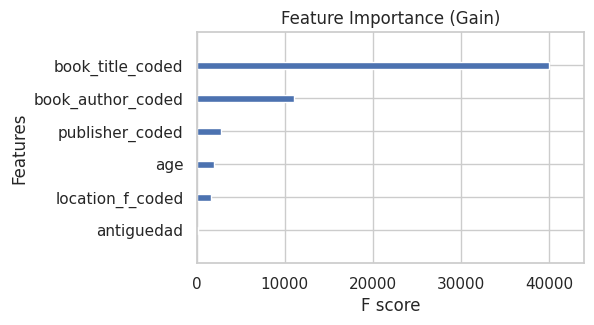

In [58]:
# Definir tamaño
fig, ax = plt.subplots(figsize=(5, 3))

# Graficar la importancia de las variables
xgb.plot_importance(xgBoost, importance_type="total_gain", ax=ax, title="Feature Importance (Gain)", show_values=False)

# Mostrar el gráfico
plt.show()

### 7. Evaluación del modelo

In [59]:
from scipy.stats import ks_2samp

# Definir métricas adicionales
def gini(y_true, y_score):
    auc = roc_auc_score(y_true, y_score)
    return 2*auc - 1

def ks_statistic(y_true, y_score):
    return ks_2samp(y_score[y_true == 1], y_score[y_true == 0]).statistic

In [60]:
# predicción del modelo
train['prediction'] = xgBoost.predict_proba(train[features])[:, 1]
test['prediction']  = xgBoost.predict_proba(test[features])[:, 1]
watch['prediction'] = xgBoost.predict_proba(watch[features])[:, 1]


In [61]:
results = pd.DataFrame(columns=['Metric', 'Train', 'Test', 'Watch'])

metrics = [
    ("Accuracy", accuracy_score),
    ("Precision", precision_score),
    ("Recall", recall_score),
    ("F1 Score", f1_score),
    ("AUC-ROC", roc_auc_score),
    ("Gini", gini),
    ("KS Statistic", ks_statistic),
    ("Jaccard", jaccard_score)
]

for metric_name, metric_func in metrics:
    if metric_name in ["Gini", "KS Statistic"]:  # Si la métrica requiere probabilidades
        train_score = metric_func(train['target'], train['prediction'])
        test_score = metric_func(test['target'], test['prediction'])
        watch_score = metric_func(watch['target'], watch['prediction'])

    else:  # Si la métrica se aplica a etiquetas
        train_score = metric_func(train['target'], train['prediction'].apply(lambda x: 1 if x > 0.5 else 0))
        test_score = metric_func(test['target'],   test['prediction'].apply(lambda x: 1 if x > 0.5 else 0))
        watch_score = metric_func(watch['target'], watch['prediction'].apply(lambda x: 1 if x > 0.5 else 0))

    results = results.append({
        'Metric': metric_name,
        'Train': train_score,
        'Test': test_score,
        'Watch': watch_score
    }, ignore_index=True)


pd.set_option('display.float_format', '{:.2f}'.format)

# Mostrar los resultados
results

,Metric,Train,Test,Watch
0,Accuracy,0.65,0.65,0.65
1,Precision,0.65,0.65,0.65
2,Recall,1.00,1.00,1.00
3,F1 Score,0.79,0.79,0.79
4,AUC-ROC,0.51,0.52,0.51
5,Gini,0.33,0.27,0.27
6,KS Statistic,0.23,0.20,0.19
7,Jaccard,0.65,0.65,0.65


### 8. ANN

In [62]:
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

In [63]:
# Estandarización

scaler = StandardScaler()
train_std = scaler.fit_transform(train[features].fillna(0))
watch_std  = scaler.transform(watch[features].fillna(0))
test_std  = scaler.transform(test[features].fillna(0))


In [64]:
# Arquitectura de la red

model = keras.Sequential([
    keras.layers.Dense(64, activation='relu', kernel_initializer='glorot_uniform', input_shape=(train_std.shape[1],)),
    #keras.layers.Dropout(0.5),  # Capa de dropout
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(16, activation='relu'),
    keras.layers.Dense(8,  activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])


In [67]:
# Compilar el modelo
#optimizer = keras.optimizers.Adam(learning_rate=0.01)  # Ajusta la tasa de aprendizaje según sea necesario
optimizer = keras.optimizers.Adagrad(learning_rate = 0.05)

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


In [68]:

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)

# Entrenar el modelo con Early Stopping y reducción de la tasa de aprendizaje
history = model.fit(train_std, train.target, epochs=100, batch_size=64, validation_data=(watch_std, watch.target), verbose=1, callbacks=[early_stopping, reduce_lr])


Epoch 1/100
536/536 [==============================] - 2s 3ms/step - loss: 0.6096 - accuracy: 0.6674 - val_loss: 0.6271 - val_accuracy: 0.6515 - lr: 0.0500
Epoch 2/100
536/536 [==============================] - 1s 2ms/step - loss: 0.6090 - accuracy: 0.6670 - val_loss: 0.6300 - val_accuracy: 0.6426 - lr: 0.0500
Epoch 3/100
536/536 [==============================] - 1s 2ms/step - loss: 0.6085 - accuracy: 0.6675 - val_loss: 0.6253 - val_accuracy: 0.6503 - lr: 0.0500
Epoch 4/100
536/536 [==============================] - 1s 2ms/step - loss: 0.6082 - accuracy: 0.6673 - val_loss: 0.6269 - val_accuracy: 0.6537 - lr: 0.0500
Epoch 5/100
536/536 [==============================] - 1s 2ms/step - loss: 0.6080 - accuracy: 0.6680 - val_loss: 0.6255 - val_accuracy: 0.6525 - lr: 0.0500
Epoch 6/100
536/536 [==============================] - 1s 2ms/step - loss: 0.6078 - accuracy: 0.6689 - val_loss: 0.6310 - val_accuracy: 0.6425 - lr: 0.0500
Epoch 7/100
536/536 [==============================] - 1s 2ms/st

In [69]:
# predicción del modelo
train['prediction'] = model.predict(scaler.transform(train[features].fillna(0)))
test['prediction']  = model.predict(scaler.transform(test[features].fillna(0)))
watch['prediction'] = model.predict(scaler.transform(watch[features].fillna(0)))


357/357 [==============================] - 0s 1ms/step


In [70]:
results_ANN = pd.DataFrame(columns=['Metric', 'Train', 'Test', 'Watch'])

metrics = [
    ("Accuracy", accuracy_score),
    ("Precision", precision_score),
    ("Recall", recall_score),
    ("F1 Score", f1_score),
    ("AUC-ROC", roc_auc_score),
    ("Gini", gini),
    ("KS Statistic", ks_statistic),
    ("Jaccard", jaccard_score)
]

for metric_name, metric_func in metrics:
    if metric_name in ["Gini", "KS Statistic"]:  # Si la métrica requiere probabilidades
        train_score = metric_func(train['target'], train['prediction'])
        test_score = metric_func(test['target'], test['prediction'])
        watch_score = metric_func(watch['target'], watch['prediction'])

    else:  # Si la métrica se aplica a etiquetas
        train_score = metric_func(train['target'], train['prediction'].apply(lambda x: 1 if x > 0.5 else 0))
        test_score = metric_func(test['target'],   test['prediction'].apply(lambda x: 1 if x > 0.5 else 0))
        watch_score = metric_func(watch['target'], watch['prediction'].apply(lambda x: 1 if x > 0.5 else 0))

    results_ANN = results_ANN.append({
        'Metric': metric_name,
        'Train': train_score,
        'Test': test_score,
        'Watch': watch_score
    }, ignore_index=True)


pd.set_option('display.float_format', '{:.2f}'.format)

# Mostrar los resultados
results_ANN

,Metric,Train,Test,Watch
0,Accuracy,0.67,0.65,0.65
1,Precision,0.68,0.67,0.67
2,Recall,0.92,0.91,0.91
3,F1 Score,0.78,0.77,0.77
4,AUC-ROC,0.57,0.55,0.55
5,Gini,0.34,0.28,0.27
6,KS Statistic,0.25,0.20,0.20
7,Jaccard,0.64,0.63,0.63


### 9. Métodos de ensamble

 <b> Output Fusion </b>

In [74]:

train['prediction_xgboost']  = xgBoost.predict_proba(train[features])[:, 1]
train['prediction_rna']      = model.predict(scaler.transform(train[features].fillna(0)))

test['prediction_xgboost']  = xgBoost.predict_proba(test[features])[:, 1]
test['prediction_rna']      = model.predict(scaler.transform(test[features].fillna(0)))

watch['prediction_xgboost']  = xgBoost.predict_proba(watch[features])[:, 1]
watch['prediction_rna']      = model.predict(scaler.transform(watch[features].fillna(0)))


357/357 [==============================] - 1s 1ms/step


In [72]:
test[['prediction_xgboost', 'prediction_rna']].head()

,prediction_xgboost,prediction_rna
149681,0.60,0.47
76194,0.64,0.63
86587,0.65,0.71
253759,0.66,0.68
369835,0.65,0.63


In [79]:
#train['prediction_output_fusion'] = (train.prediction_xgboost + train.prediction_rna)/2
#test['prediction_output_fusion']  = (test.prediction_xgboost + test.prediction_rna)/2
#watch['prediction_output_fusion'] = (watch.prediction_xgboost + watch.prediction_rna)/2

train['prediction_output_fusion'] = 2/(1/train.prediction_xgboost + 1/train.prediction_rna)
test['prediction_output_fusion']  = 2/(1/test.prediction_xgboost  + 1/test.prediction_rna)
watch['prediction_output_fusion'] = 2/(1/watch.prediction_xgboost + 1/watch.prediction_rna)

In [81]:
results_output_fusion = pd.DataFrame(columns=['Metric', 'Train', 'Test', 'Watch'])

metrics = [
    ("Accuracy", accuracy_score),
    ("Precision", precision_score),
    ("Recall", recall_score),
    ("F1 Score", f1_score),
    ("AUC-ROC", roc_auc_score),
    ("Gini", gini),
    ("KS Statistic", ks_statistic),
    ("Jaccard", jaccard_score)
]

for metric_name, metric_func in metrics:
    if metric_name in ["Gini", "KS Statistic"]:  # Si la métrica requiere probabilidades
        train_score = metric_func(train['target'], train['prediction_output_fusion'])
        test_score = metric_func(test['target'], test['prediction_output_fusion'])
        watch_score = metric_func(watch['target'], watch['prediction_output_fusion'])

    else:  # Si la métrica se aplica a etiquetas
        train_score = metric_func(train['target'], train['prediction_output_fusion'].apply(lambda x: 1 if x > 0.5 else 0))
        test_score = metric_func(test['target'],   test['prediction_output_fusion'].apply(lambda x: 1 if x > 0.5 else 0))
        watch_score = metric_func(watch['target'], watch['prediction_output_fusion'].apply(lambda x: 1 if x > 0.5 else 0))

    results_output_fusion = results_output_fusion.append({
        'Metric': metric_name,
        'Train': train_score,
        'Test': test_score,
        'Watch': watch_score
    }, ignore_index=True)


pd.set_option('display.float_format', '{:.2f}'.format)

# Mostrar los resultados
results_output_fusion

,Metric,Train,Test,Watch
0,Accuracy,0.66,0.66,0.66
1,Precision,0.66,0.66,0.66
2,Recall,0.98,0.97,0.97
3,F1 Score,0.79,0.78,0.78
4,AUC-ROC,0.54,0.53,0.53
5,Gini,0.34,0.28,0.27
6,KS Statistic,0.24,0.20,0.20
7,Jaccard,0.65,0.64,0.64


In [77]:
results_ANN

,Metric,Train,Test,Watch
0,Accuracy,0.67,0.65,0.65
1,Precision,0.68,0.67,0.67
2,Recall,0.92,0.91,0.91
3,F1 Score,0.78,0.77,0.77
4,AUC-ROC,0.57,0.55,0.55
5,Gini,0.34,0.28,0.27
6,KS Statistic,0.25,0.20,0.20
7,Jaccard,0.64,0.63,0.63


In [78]:
results

,Metric,Train,Test,Watch
0,Accuracy,0.65,0.65,0.65
1,Precision,0.65,0.65,0.65
2,Recall,1.00,1.00,1.00
3,F1 Score,0.79,0.79,0.79
4,AUC-ROC,0.51,0.52,0.51
5,Gini,0.33,0.27,0.27
6,KS Statistic,0.23,0.20,0.19
7,Jaccard,0.65,0.65,0.65


 <b> Weighted ensemble recommender </b>

<b> Staking methods </b>

### 8. Utilizando nuestro RecSys

In [ ]:
# Seleccionamos un cliente cualquiera
test[test.user_id == 16795].head()


In [ ]:
train[train.user_id == 16795].head()


In [ ]:
train[train.user_id == 16795][['user_id'] + features].head()

In [ ]:
df_user = test[test.user_id == 16795][['user_id', 'age', 'location_f', 'location_f_coded']].drop_duplicates()
df_user.head()

In [ ]:
# Información de todos los ítems
df_books = train[['antiguedad',	'book_title',	'book_author',	'publisher', 'book_title_coded',	'book_author_coded',	'publisher_coded']].drop_duplicates()
df_books['user_id'] =  16795

In [ ]:

df_user_items = pd.merge(df_user, df_books, on = 'user_id', how = 'left')
df_user_items.head()


In [ ]:
df_user_items['prediction'] = xgBoost.predict_proba(df_user_items[features])[:, 1]
df_user_items = df_user_items.sort_values(by = 'prediction', ascending = False).drop_duplicates()
df_user_items.head()

In [ ]:
# Items que el sistema le recomienda
df_user_items[df_user_items.prediction > 0.5].head(10).book_title.tolist()

In [ ]:
# Items que vio
test[(test.user_id == 16795) & (test.book_rating > 6)].head(10).book_title.tolist()


In [ ]:
train[(train.user_id == 16795) & (train.book_rating > 6)].head(10).book_title.tolist()


---
## Gracias por completar este laboratorio!